# <b>PA005: High Value Customer Identification (Insiders)</b>

### 0.0 Imports

In [1]:
import re
import pickle
import numpy   as np
import pandas  as pd
import seaborn as sns

import plotly.express    as px
import matplotlib.pyplot as plt

from matplotlib import colormaps

from sklearn.cluster       import KMeans, DBSCAN
from sklearn.metrics       import silhouette_score, silhouette_samples
from sklearn.manifold      import TSNE
from sklearn.ensemble      import RandomForestRegressor
from sklearn.mixture       import GaussianMixture
from sklearn.neighbors     import NearestNeighbors
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

import sklearn.preprocessing as pp

import umap.umap_ as umap


### 0.2 Load dataset

In [2]:
# load data
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='latin')

# drop extra column
df_raw = df_raw.drop( columns=['Unnamed: 8'], axis=1 )


df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## <font color="blue">1.0 Descrição dos dados </font>

In [3]:
df1 = df_raw.copy()

### 1.1 Rename columns

In [4]:
cols_name = df1.columns

df1.columns = map( lambda col: re.sub(r'([a-z])([A-Z])', r'\1_\2', col).lower(), cols_name )

df1.columns


Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

### 1.2 Data dimensions

In [5]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 541909
Number of cols: 8


### 1.3 Data types

In [6]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

Variáveis como `invoice_no` e `invoice_date` não estão com o tipo correto.

### 1.4 Check NA

In [7]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 1.5 Replace NA

In [8]:
df_missing     = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

df_missing.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
622,536414,22139,NaN,56,29-Nov-16,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,29-Nov-16,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,29-Nov-16,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,29-Nov-16,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,29-Nov-16,1.66,NaN,United Kingdom


In [9]:
# dataframe com os códigos de transação de compras sem identificação do cliente
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange( 19000, 19000 + df_backup.shape[0], 1 )

# merge with original
df1 = pd.merge( df1, df_backup, how='left', on='invoice_no')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


### 1.6 Change dtypes

In [10]:
# converte para o tipo 'datetime64[ns]'
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y')

# converte para o tipo inteiro
df1['customer_id'] = df1['customer_id'].astype( int )

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [11]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

### 1.7 Descriptive Statistics

In [12]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

#### 1.7.1 Numerical Attributes

In [13]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply(np.mean) ).T
ct2 = pd.DataFrame( num_attributes.apply(np.median) ).T

# dispersion - desvio padrão, mínimo, máximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
desc_stats = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
desc_stats.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurt']

desc_stats

,attributes,min,max,range,mean,median,std,skew,kurt
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


#### 1.7.1 Categorical Attributes

#### `invoice_no`

A variável `invoice_no` possui o tipo `object`, isso indica a existência de caracteres não-numéricos em algum dos registros.

In [14]:
# recebe os indices em que 'invoice_no' possui uma letra
notint_index = cat_attributes['invoice_no'].apply( lambda x: bool(re.search(r'[a-zA-Z]', x)) )

# verifica a quantidade de pedidos 'especiais'
# (as repetições de invoice_no indicam a compra de diferentes itens dentro de uma mesma transação)
cat_attributes.loc[notint_index, 'invoice_no'].drop_duplicates().shape

(3839,)

Existem 3839 (*anteriormente 3654*) pedidos com algum com algum caractere não-numérico.

As letras em `invoice_no` indica algum registro que não se trata de um pedido não-convencional, como devoluções ou brindes. Filtrando a tabela pelos indices, vemos tais pedidos.

In [15]:
df1.loc[notint_index, :]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
141,C536379,D,Discount,-1,2016-11-29,27.50,United Kingdom,14527
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,United Kingdom,15311
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,United Kingdom,17548
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,United Kingdom,17548
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,United Kingdom,17548
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2017-12-07,0.83,United Kingdom,14397
541541,C581499,M,Manual,-1,2017-12-07,224.69,United Kingdom,15498
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2017-12-07,10.95,United Kingdom,15311
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2017-12-07,1.25,United Kingdom,17315


In [16]:
# quantidade de linhas com 'quantity' < 0
( df1.loc[notint_index, 'quantity'] < 0 ).sum()

9288

Vemos que todos os itens da tabela filtrada possuem `quantity` < 0, ou seja, muito provavelmente se tratam de devoluções ou o estorno da compra.

#### `stock_code`

Por se tratar do código do item não tem problema essa variável ser do tipo `object`.

In [17]:
df1.shape

(541909, 8)

In [18]:
# stock code
notint_index = cat_attributes['stock_code'].apply( lambda x: bool(re.search(r'[a-zA-Z]', x)) )

cat_attributes.loc[notint_index, 'stock_code']

0         85123A
2         84406B
3         84029G
4         84029E
45          POST
           ...  
541778    84997C
541809    85099C
541838    84993A
541844    85049A
541853    85049E
Name: stock_code, Length: 54873, dtype: object

Acima podemos identificar que existem valores de `stock_code` formados apenas por letras (POST). Assim como ocorreu com `invoice_no` no qual itens que possuiam algum caractere não-numérico identificava uma transação não-convencional (devolução), vamos verificar se o mesmo ocorre com `stock_code`, ou seja, se valores compostos apenas por letras são usados para indicar etapas da compra e não um item comprado propriamente dito.

In [19]:
# verifica quais registros o valor 'stock_code' é compostos apenas por letras
notint_index = cat_attributes['stock_code'].apply( lambda x: bool(re.search(r'^[a-zA-Z]+$', x)) )

# identifica as categorias
cat_attributes.loc[notint_index, 'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [20]:
df1.query("stock_code in ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY','DCGSSGIRL', 'PADS', 'B', 'CRUK']").shape

(2759, 8)

Acima vemos que existem 2759 (*anteriormente 1774*) registros com `stock_code = ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']` (surgiram novas categorias). Alguns desses valores não fica muito claro o significado como 'PADS' ou 'CRUK', mas podemos concluir que eles não se trata da compra de produtos.

In [21]:
df1.loc[notint_index, 'stock_code'].value_counts()

stock_code
POST         1256
DOT           710
M             571
D              77
S              63
AMAZONFEE      34
CRUK           16
DCGSSGIRL      13
DCGSSBOY       11
PADS            4
B               3
m               1
Name: count, dtype: int64

#### `description`

In [22]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


Nesse primeiro momento vamos descartar a coluna `description`, mas ela poderá ser usada em ciclo futuro. 

#### `country`

In [23]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [24]:
df1.drop_duplicates(subset=['customer_id'])['country'].value_counts()

country
United Kingdom          7587
Germany                   95
France                    90
EIRE                      44
Spain                     29
Belgium                   24
Switzerland               23
Portugal                  20
Hong Kong                 15
Italy                     15
Finland                   12
Norway                    10
Australia                  9
Netherlands                9
Austria                    9
Unspecified                9
Channel Islands            9
Sweden                     8
Denmark                    8
Japan                      8
Israel                     7
Cyprus                     7
Poland                     6
USA                        4
Canada                     4
Bahrain                    4
Greece                     4
United Arab Emirates       2
Malta                      2
Lithuania                  1
Iceland                    1
Saudi Arabia               1
Singapore                  1
Lebanon                    1
Brazil

Existem 2 valores em `country` que não representam países: "Unspecified" e "European Community". Esses valores serão descartados na etapa de Filtragem de Variáveis.

## <font color="blue">2.0 Filtragem de Variáveis </font>

In [25]:
df2 = df1.copy()

In [26]:
# ==== Numerical Attributes =========
# unit price > 0.04 - elimina possíveis brindes
df2 = df2.query('unit_price > 0.04')

# ==== Categorical attributes =======
# stock code != ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']
df2 = df2.query("stock_code not in ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']")

# description
df2 = df2.drop(columns=['description'], axis=1)

# country - elimina falsos paises
df2 = df2.query("country not in ['Unspecified', 'European Community']")

# bad users
df2 = df2.query('customer_id not in [16446]')

# dividindo o dataset entre compras e devoluções
df2_returns  = df2.query('quantity < 0')
df2_purchases = df2.query('quantity > 0')

## <font color="blue">3.0 Feature Engineering </font>

In [27]:
df3 = df2.copy()

### 3.1 Feature Creation

In [28]:
# data reference
df_ref = df3[['customer_id']].drop_duplicates(ignore_index=True)

df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


#### 3.1.1 Gross Revenue

In [29]:
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases['quantity'] * df2_purchases['unit_price']

df_monetary = ( df2_purchases[['customer_id', 'gross_revenue']]
                    .groupby('customer_id')
                    .sum()
                    .reset_index()
            )

df_ref = pd.merge(left=df_ref, right=df_monetary, how='left', on='customer_id')

df_ref.isna().sum()


/tmp/ipykernel_11479/599400605.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases.loc[:, 'gross_revenue'] = df2_purchases['quantity'] * df2_purchases['unit_price']


customer_id       0
gross_revenue    91
dtype: int64

#### 3.1.2 Recency - Days from lastest purchase on the dataset

In [30]:
df_recency = ( df2_purchases[['customer_id', 'invoice_date']]
                    .groupby('customer_id')
                    .max()
                    .reset_index()
            )

df_recency['recency_days'] = ( df2_purchases['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']]

df_ref = pd.merge(left=df_ref, right=df_recency, how='left', on='customer_id')

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

#### 3.1.5 Amount of products bought

In [31]:
df_products = ( df2_purchases[['customer_id', 'stock_code']]
                    .groupby('customer_id')
                    .count()
                    .reset_index()
        ).rename(columns={'stock_code': 'total_products'})


df_ref = pd.merge(left=df_ref, right=df_products, how='left', on='customer_id')

df_ref.isna().sum()

customer_id        0
gross_revenue     91
recency_days      91
total_products    91
dtype: int64

#### 3.1.7 Average time between orders

In [32]:
df_aux = df2_purchases[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=[True, True])

df_aux['next_customer_id']  = df_aux['customer_id'].shift(periods=-1)
df_aux['next_invoice_date'] = df_aux['invoice_date'].shift(periods=-1)

df_aux.head()

,customer_id,invoice_date,next_customer_id,next_invoice_date
61619,12346,2017-01-16,12347.0,2016-12-05
14938,12347,2016-12-05,12347.0,2017-01-24
72246,12347,2017-01-24,12347.0,2017-04-05
148285,12347,2017-04-05,12347.0,2017-06-07
220572,12347,2017-06-07,12347.0,2017-07-31


In [33]:
df_aux['time_delta'] = df_aux.apply( lambda x: (x['next_invoice_date'] - x['invoice_date']).days if x['customer_id'] == x['next_customer_id'] 
                                                                                                 else 
                                                np.nan, 
                                    axis=1
                )

df_aux.head(10)

,customer_id,invoice_date,next_customer_id,next_invoice_date,time_delta
61619,12346,2017-01-16,12347.0,2016-12-05,NaN
14938,12347,2016-12-05,12347.0,2017-01-24,50.0
72246,12347,2017-01-24,12347.0,2017-04-05,71.0
148285,12347,2017-04-05,12347.0,2017-06-07,63.0
220572,12347,2017-06-07,12347.0,2017-07-31,54.0
286621,12347,2017-07-31,12347.0,2017-10-29,90.0
428957,12347,2017-10-29,12347.0,2017-12-05,37.0
535004,12347,2017-12-05,12348.0,2016-12-14,NaN
34083,12348,2016-12-14,12348.0,2017-01-23,40.0
70051,12348,2017-01-23,12348.0,2017-04-03,70.0


In [34]:
df_aux = df_aux.drop(['invoice_date', 'next_invoice_date', 'next_customer_id'], axis=1).dropna()

df_aux = ( df_aux[['customer_id', 'time_delta']]
            .groupby('customer_id')
            .mean()
            .reset_index()
            
    ).rename(columns={'time_delta':'avg_days_orders'})

df_aux.head()

,customer_id,avg_days_orders
0,12347,60.833333
1,12348,94.333333
2,12352,43.333333
3,12356,151.500000
4,12358,149.000000


In [35]:
df_ref = pd.merge(df_ref, df_aux, on='customer_id', how='left')

df_ref.isna().sum()

customer_id           0
gross_revenue        91
recency_days         91
total_products       91
avg_days_orders    3013
dtype: int64

#### 3.1.8 Frequency Purchase

In [36]:
df_aux =  ( df2_purchases[['customer_id', 'invoice_no', 'invoice_date']]
              .drop_duplicates()
              .groupby('customer_id')
              .agg(
                    max_date=('invoice_date', 'max'),
                    min_date=('invoice_date', 'min'),
                    orders=('invoice_date', 'count'),
                  )
              .reset_index()
        )

df_aux['days'] = ( df_aux['max_date'] - df_aux['min_date'] ).dt.days

df_aux['frequency'] = df_aux[['orders', 'days']].apply( lambda x: x['orders'] / x['days'] if x['days'] != 0 else 0, axis=1)

df_aux.head()

,customer_id,max_date,min_date,orders,days,frequency
0,12346,2017-01-16,2017-01-16,1,0,0.000000
1,12347,2017-12-05,2016-12-05,7,365,0.019178
2,12348,2017-09-23,2016-12-14,4,283,0.014134
3,12349,2017-11-19,2017-11-19,1,0,0.000000
4,12350,2017-01-31,2017-01-31,1,0,0.000000


In [37]:
df_aux.sort_values('frequency', ascending=False)

,customer_id,max_date,min_date,orders,days,frequency
4007,17850,2016-11-30,2016-11-29,34,1,34.0
4219,18139,2017-11-20,2017-11-19,6,1,6.0
1979,15060,2017-11-29,2017-11-28,4,1,4.0
2461,15700,2017-06-18,2017-06-17,2,1,2.0
3395,16986,2017-11-08,2017-11-07,2,1,2.0
...,...,...,...,...,...,...
788,13398,2017-05-29,2017-05-29,1,0,0.0
790,13403,2017-11-20,2017-11-20,1,0,0.0
777,13382,2017-03-02,2017-03-02,1,0,0.0
779,13385,2017-01-12,2017-01-12,1,0,0.0


In [38]:
df_aux = df_aux[['customer_id', 'frequency']]

df_ref = pd.merge(df_ref, df_aux, on='customer_id', how='left')

df_ref.isna().sum()

customer_id           0
gross_revenue        91
recency_days         91
total_products       91
avg_days_orders    3013
frequency            91
dtype: int64

#### 3.1.9 Number of returns

In [39]:
df_aux = ( df2_returns[['customer_id', 'quantity']]
            .groupby('customer_id')
            .sum()
            .reset_index()
            .rename(columns={'quantity': 'items_returned'})
    )

df_aux['items_returned'] = -1 * df_aux['items_returned']

df_ref = pd.merge(left=df_ref, right=df_aux, on='customer_id', how='left')

df_ref.isna().sum()

customer_id           0
gross_revenue        91
recency_days         91
total_products       91
avg_days_orders    3013
frequency            91
items_returned     4191
dtype: int64

In [40]:
df_ref.loc[ df_ref['items_returned'].isna(), 'items_returned' ] = 0

df_ref.isna().sum()

customer_id           0
gross_revenue        91
recency_days         91
total_products       91
avg_days_orders    3013
frequency            91
items_returned        0
dtype: int64

### 3.2 Final Result

In [41]:
df_ref.isna().sum()

customer_id           0
gross_revenue        91
recency_days         91
total_products       91
avg_days_orders    3013
frequency            91
items_returned        0
dtype: int64

## <font color="blue">4.0 Exploratory Data Analysis </font>

In [42]:
df4 = df_ref.dropna().copy()
df4.isna().sum()

customer_id        0
gross_revenue      0
recency_days       0
total_products     0
avg_days_orders    0
frequency          0
items_returned     0
dtype: int64

In [43]:
df4.head()

,customer_id,gross_revenue,recency_days,total_products,avg_days_orders,frequency,items_returned
0,17850,5391.21,372.0,297.0,1.000000,34.000000,40.0
1,13047,3232.59,56.0,171.0,52.833333,0.028391,35.0
2,12583,6705.38,2.0,232.0,26.500000,0.040431,50.0
3,13748,948.25,95.0,28.0,92.666667,0.017986,0.0
4,15100,876.00,333.0,3.0,20.000000,0.075000,22.0


### 4.3 Estudo do Espaço

In [67]:
df43 = df4.drop(columns=['customer_id', 'avg_days_orders'], axis=1).copy()

df43.head()

,gross_revenue,recency_days,total_products,frequency,items_returned
0,5391.21,372.0,297.0,34.000000,40.0
1,3232.59,56.0,171.0,0.028391,35.0
2,6705.38,2.0,232.0,0.040431,50.0
3,948.25,95.0,28.0,0.017986,0.0
4,876.00,333.0,3.0,0.075000,22.0


In [68]:
mms = pp.MinMaxScaler()

scaled_features = mms.fit_transform(df43)

df43 = pd.DataFrame(data=scaled_features, columns=df43.columns)

cols_selected = ['gross_revenue', 'recency_days', 'total_products', 'frequency', 'items_returned']

df43 = df43[cols_selected]
df43.head()

,gross_revenue,recency_days,total_products,frequency,items_returned
0,0.019185,1.000000,0.037652,1.000000,0.004438
1,0.011451,0.150538,0.021570,0.000674,0.003883
2,0.023894,0.005376,0.029355,0.001029,0.005547
3,0.003267,0.255376,0.003318,0.000368,0.000000
4,0.003008,0.895161,0.000128,0.002045,0.002441


In [69]:
pickle.dump(obj=mms, file=open('../src/features/min-max-feature-scaler.pkl', mode='wb'))

In [70]:
X = df43.values

#### 4.3.4 Tree-Based Embedding

In [79]:
df43 = df4.drop(columns=['customer_id'], axis=1)

Em muitos problemas o faturamento total do cliente é a variável de interesse. Vamos criar uma árvore para prever o `gross_revenue`.

In [80]:
X = df4.drop(columns=['customer_id', 'gross_revenue', 'avg_days_orders'], axis=1)
y = df4['gross_revenue']

# model definition
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# model training
rf_model.fit(X, y)

# leaf
df_leaf = pd.DataFrame( rf_model.apply(X) )

# dataframe leaf
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,3416,3176,3339,3490,3048,3333,3248,3333,3512,3228,...,3139,3345,3421,3422,3294,3409,3294,3227,3284,3181
1,2953,3062,2838,2626,2816,3266,3105,3178,2831,3037,...,2727,3217,2798,2999,3125,3315,2973,3019,2501,3049
2,3071,3191,3217,3340,2914,3347,3138,3242,3409,3164,...,3129,3235,3339,3016,3258,3342,2732,3164,3382,3159
3,696,986,973,692,918,503,862,298,660,575,...,969,298,726,964,300,607,985,1150,1200,1158
4,418,535,575,1094,41,611,1670,716,858,264,...,363,761,1073,526,642,1041,1909,552,504,543


In [81]:
pickle.dump(obj=rf_model, file=open('../src/models/random-forest-embedder.pkl', mode='wb'))

In [82]:
X.shape

(2773, 4)

In [83]:
df_leaf.shape

(2773, 100)

In [84]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(df_leaf)

pickle.dump(obj=reducer, file=open('../src/features/umap-reducer.pkl', mode='wb'))

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

## <font color="blue">5.0 Data Preparation </font>

In [103]:
# df5 = df4.copy()
df5 = df_tree.copy()

## <font color="blue">6.0 Feature Selection </font>

In [104]:
df6 = df5.copy()

## <font color="blue">7.0 Hyperparameter Fine-Tuning </font>

In [105]:
# X = df6.drop(columns=['customer_id'])
X = df_tree.copy()

In [106]:
X.head()

,embedding_x,embedding_y
0,6.596718,19.752171
1,18.960011,13.049649
2,6.501558,19.478197
3,1.102331,5.415567
4,2.717085,2.582875


## <font color="blue">8.0 Model Training </font>

### 8.1 K-Means

In [107]:
# model definition
k_best = 8
kmeans = KMeans(init='random', n_clusters=k_best, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X.values)

# clustering
labels = kmeans.labels_

## <font color="blue">9.0 Cluster Analysis </font>

In [108]:
df9 = X.copy()

df9['cluster'] = labels
df9.head()

,embedding_x,embedding_y,cluster
0,6.596718,19.752171,7
1,18.960011,13.049649,4
2,6.501558,19.478197,7
3,1.102331,5.415567,3
4,2.717085,2.582875,3


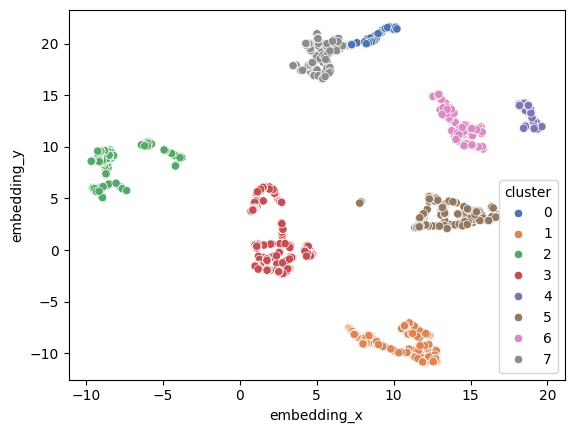

In [109]:
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep');

In [110]:
df9 = df4.copy()
df9['cluster'] = labels

df9['recency_days'] = df9['recency_days'].astype(int)
df9['total_products'] = df9['total_products'].astype(int)
df9['items_returned'] = df9['items_returned'].astype(int)


df9.head()

,customer_id,gross_revenue,recency_days,total_products,avg_days_orders,frequency,items_returned,cluster
0,17850,5391.21,372.0,297.0,1.000000,34.000000,40.0,7
1,13047,3232.59,56.0,171.0,52.833333,0.028391,35.0,4
2,12583,6705.38,2.0,232.0,26.500000,0.040431,50.0,7
3,13748,948.25,95.0,28.0,92.666667,0.017986,0.0,3
4,15100,876.00,333.0,3.0,20.000000,0.075000,22.0,3


In [111]:
# Number of customers
df_cluster = ( df9[['customer_id', 'cluster']]
                .groupby('cluster')
                .count()
                .reset_index()

        ).rename(columns={'customer_id': 'customers'})

df_cluster['perc_customer'] = 100 * df_cluster['customers'] / df_cluster['customers'].sum()

# Avg gross revenue
df_gross_revenue = ( df9[['gross_revenue', 'cluster']]
                        .groupby('cluster')
                        .mean()
                        .reset_index()
            )

df_cluster = pd.merge(left=df_cluster, right=df_gross_revenue, how='left', on='cluster')


# Avg recency days
df_recency = ( df9[['recency_days', 'cluster']]
                        .groupby('cluster')
                        .mean()
                        .reset_index()
            )

df_cluster = pd.merge(left=df_cluster, right=df_recency, how='left', on='cluster')


# Avg frequency
df_frequency = ( df9[['frequency', 'cluster']]
                        .groupby('cluster')
                        .mean()
                        .reset_index()
            )

df_cluster = pd.merge(left=df_cluster, right=df_frequency, how='left', on='cluster')


df_total_products = ( df9[['total_products', 'cluster']]
                        .groupby('cluster')
                        .mean()
                        .reset_index()
            )

df_cluster = pd.merge(left=df_cluster, right=df_total_products, how='left', on='cluster')


df_items_returned = ( df9[['items_returned', 'cluster']]
                        .groupby('cluster')
                        .mean()
                        .reset_index()
            )

df_cluster = pd.merge(left=df_cluster, right=df_items_returned, how='left', on='cluster')


df_cluster

,cluster,customers,perc_customer,gross_revenue,recency_days,frequency,total_products,items_returned
0,0,133,4.796250,2646.804962,28.661654,0.034408,234.796992,2.127820
1,1,467,16.840966,1254.547473,58.685225,0.033886,57.591006,7.736617
2,2,421,15.182113,580.657577,94.370546,0.077376,14.368171,1.111639
3,3,488,17.598269,957.693156,77.020492,0.042992,33.000000,8.719262
4,4,161,5.805986,3129.955404,35.391304,0.076690,171.956522,23.142857
5,5,438,15.795168,2657.591530,51.735160,0.037486,97.127854,26.776256
6,6,333,12.008655,2395.133033,42.486486,0.044179,127.555556,17.105105
7,7,332,11.972593,11366.828946,18.210843,0.162753,502.620482,202.448795


In [112]:
most_valuable_cluster = df_cluster.sort_values('gross_revenue', ascending=False)['cluster'].values
new_cluster_labels = np.arange(k_best)
dict_cluster = dict(zip(most_valuable_cluster, new_cluster_labels))

df_cluster['cluster'] = df_cluster['cluster'].map(dict_cluster)

df_cluster = df_cluster.sort_values('gross_revenue', ascending=False)
df_cluster

,cluster,customers,perc_customer,gross_revenue,recency_days,frequency,total_products,items_returned
7,0,332,11.972593,11366.828946,18.210843,0.162753,502.620482,202.448795
4,1,161,5.805986,3129.955404,35.391304,0.076690,171.956522,23.142857
5,2,438,15.795168,2657.591530,51.735160,0.037486,97.127854,26.776256
0,3,133,4.796250,2646.804962,28.661654,0.034408,234.796992,2.127820
6,4,333,12.008655,2395.133033,42.486486,0.044179,127.555556,17.105105
1,5,467,16.840966,1254.547473,58.685225,0.033886,57.591006,7.736617
3,6,488,17.598269,957.693156,77.020492,0.042992,33.000000,8.719262
2,7,421,15.182113,580.657577,94.370546,0.077376,14.368171,1.111639


In [113]:
most_valuable_cluster_index = np.argsort(most_valuable_cluster)

labels = most_valuable_cluster_index[labels]
labels

array([0, 1, 0, ..., 6, 0, 4])

## <font color="blue">10.0 Análise Explatória dos Clusters </font>

In [114]:
df10 = df9[['customer_id'] + cols_selected].copy()
df10['cluster'] = labels

#### Hipóteses de Compra

##### H1: Os clientes do Cluster Insiders possuem um volume (produtos) de compra acima de 10% do total de compras.

**Verdade:** O cluster Insiders possui um volume de compra de produtos de 35%

In [115]:
# soma quantidade produtos Insiders
sales_insiders = df10.query('cluster == 0')['total_products'].sum()
sales_total = df10['total_products'].sum()

print('% Sales Insiders: {:.2f}%'.format(100 * sales_insiders / sales_total))

% Sales Insiders: 46.37%


##### H2: Os clientes do Cluster Insiders possuem um volume (faturamento) de compra acima de 10% do total de compras.

**Verdade:** O cluster Insiders possui um faturamento de 55%

In [116]:
# soma faturamento Insiders
gross_margin_insiders = df10.query('cluster == 0')['gross_revenue'].sum()
gross_margin_total = df10['gross_revenue'].sum()

print('% gross_margin Insiders: {:.2f}%'.format(100 * gross_margin_insiders / gross_margin_total))

% gross_margin Insiders: 47.84%


##### H3: Os clientes do Cluster Insiders possuem o número de devoluções médio abaixo da média da base total de clientes.

**Falso:** O cluster Insiders tem média de devoluções acima da média geral.

In [117]:
# media de devolucao do cluster insiders
avg_returned_insiders = df10.query('cluster == 0')['items_returned'].mean()

# media de devolucao total
avg_returned = df10['items_returned'].mean()

print('Insiders: {:.2f}\nTotal: {:.2f}'.format(avg_returned_insiders, avg_returned))

Insiders: 202.45
Total: 34.97


#### Hipóteses de Produto

##### H4: A mediana do faturamento pelos clientes do cluster insider é 10% maior do que a mediana do faturamento geral

**Verdadeiro:** A mediana do faturamento é 502% acima da média

In [118]:
# mediana gmv insiders
median_gmv_insiders = df10.query('cluster == 0')['gross_revenue'].median()

# mediana gmv total
median_gmv_total = df10['gross_revenue'].median()

print('Median Insiders: {}\nMedian Total: {}'.format(median_gmv_insiders, median_gmv_total))

gmv_diff = (median_gmv_insiders - median_gmv_total) / median_gmv_total

print('Median Diff: {:.2f}%'.format(100 * gmv_diff))

Median Insiders: 5134.700000000001
Median Total: 1169.94
Median Diff: 338.89%


##### H5: O GMV dos clientes Insiders está concentrado no terceiro quartil

**Falso.** O faturamento do cluster Insiders está concentrado no quartil 2

In [119]:
for p in range(10, 100, 10):
    percentil = np.percentile(df10.loc[df10['cluster'] == 0, 'gross_revenue'], q=p)
    print('percentil: {} -> gross revenue: {:.2f}'.format(p, percentil))

percentil: 10 -> gross revenue: 2089.27
percentil: 20 -> gross revenue: 2800.79
percentil: 30 -> gross revenue: 3617.25
percentil: 40 -> gross revenue: 4191.48
percentil: 50 -> gross revenue: 5134.70
percentil: 60 -> gross revenue: 6096.33
percentil: 70 -> gross revenue: 7244.31
percentil: 80 -> gross revenue: 10608.62
percentil: 90 -> gross revenue: 18542.36


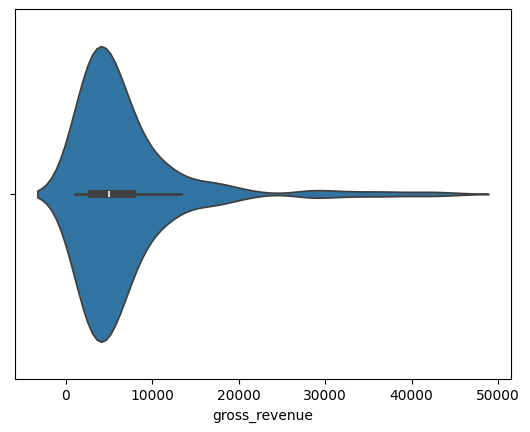

In [120]:
sns.violinplot(x=df10.query('cluster == 0 and gross_revenue < 50000')['gross_revenue']);

#### Hipóteses de Cliente

#### Perguntas de Negócio

#### 1. Quem são as pessoas elegíveis para participar do programa de Insiders?

In [121]:
df10.query('cluster == 0')['customer_id'].head()

0     17850
2     12583
6     14688
8     15311
12    16029
Name: customer_id, dtype: int64

#### 2. Quantos clientes farão parte do grupo?

In [122]:
df10.query('cluster == 0').shape[0]

332

#### 3. Quais as principais características desses clientes?

In [123]:
df_cluster.query('cluster == 0')

,cluster,customers,perc_customer,gross_revenue,recency_days,frequency,total_products,items_returned
7,0,332,11.972593,11366.828946,18.210843,0.162753,502.620482,202.448795


**Cluster 01: (Candidato a Insider)**
- Número de customers: 252 ( 9% dos clientes )
- Recência média: 18 dias
- Média de produtos comprados: 466 produtos
- Receita média: $ 16785

#### 4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders?

In [124]:
insiders_gmv = df10.query('cluster == 0')['gross_revenue'].sum()
all_gmv = df10['gross_revenue'].sum()

print('% GMV contribution: {:.2f}%'.format(100 * insiders_gmv / all_gmv))

% GMV contribution: 47.84%


#### 5. Qual a expectativa de faturamento desse grupo para os próximos meses?

#### 6. Quais as condições para uma pessoa ser elegível ao Insiders?

7. Quais as condições para uma pessoa ser removida do Insiders?

8. Qual a garantia que o programa Insiders é melhor que o restante da base?

9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

### 10.3 Priorização das Hipóteses

### 10.4 Validação das Hipóteses

### 10.5 Quadro de Respostas

## <font color="blue">11.0 Deploy to Production </font>

In [129]:
df10.dtypes

customer_id         int64
gross_revenue     float64
recency_days        int64
total_products      int64
frequency         float64
items_returned      int64
cluster             int64
dtype: object

### Inserting into SQLite

In [132]:
import sqlite3
from sqlalchemy import create_engine

In [134]:
# create table
query_create_table_insiders = """
    CREATE TABLE insiders (
        customer_id     INTEGER,
        gross_revenue   REAL,
        recency_days    INTEGER,
        total_products  INTEGER,
        frequency       REAL,
        items_returned  INTEGER,
        cluster         INTEGER
    )
"""

conn = sqlite3.connect('insiders_db.sqlite')
conn.execute(query_create_table_insiders)
conn.commit()
conn.close()

# insert data
conn = create_engine('sqlite:///insiders_db.sqlite')
df10.to_sql('insiders', con=conn, if_exists='append', index=False)

# select data

2773

In [135]:
query = """
    SELECT * FROM insiders
"""

df = pd.read_sql_query(query, conn)
df.head()

,customer_id,gross_revenue,recency_days,total_products,frequency,items_returned,cluster
0,17850,5391.21,372,297,34.000000,40,0
1,13047,3232.59,56,171,0.028391,35,1
2,12583,6705.38,2,232,0.040431,50,0
3,13748,948.25,95,28,0.017986,0,6
4,15100,876.00,333,3,0.075000,22,6
